# 🩺 ColpoTool – Arquitectura ColpoNet para Detección de Lesiones Cervicales

## 📘 Descripción

Este notebook presenta el desarrollo e implementación de **ColpoNet**, la arquitectura de inteligencia artificial de **ColpoTool**, una aplicación diseñada para el análisis automatizado de imágenes colposcópicas y datos clínicos. El objetivo es apoyar el diagnóstico médico en la detección de lesiones cervicales mediante la integración de técnicas de **Deep Learning** y **Machine Learning**.

---

## 🎯 Objetivo

Desarrollar una arquitectura inteligente que, a partir de imágenes colposcópicas y datos clínicos, permita segmentar lesiones, clasificarlas según su tipo, identificar si la imagen es normal o anormal, y predecir el riesgo de cáncer, integrando modelos de aprendizaje profundo y aprendizaje automático en una solución funcional y clínicamente útil.

---

## 🖼️ Arquitectura gráfica


<img src="colponet_diagrama.png" alt="Arquitectura ColpoNet" width="300"/>

---

## 🏛️ Información del proyecto

- **Proyecto**: Plataforma Inteligente para Análisis de Lesiones Cervicales – *ColpoTool*
- **Programa**: Proyecto VLIR-UOS – Fase de Desarrollo Tecnológico
- **Universidad**: Universidad Técnica Particular de Loja (UTPL), Ecuador
- **Departamento**: Ciencias de la Computación y Departamento de Química
- **Línea de investigación**: Inteligencia Artificial Aplicada a la Medicina

---

## 👤 Autor

- **Nombre**: Ramiro Vivanco  
- **Programa**: Maestría en Inteligencia Artificial Aplicada  
- **Correo institucional**: rivivanco@utpl.edu.ec  
---

## 1. Configuración del entorno

En esta sección se realiza la configuración inicial del entorno de trabajo para el desarrollo de la arquitectura **ColpoNet**. Esto incluye:

- Importación de librerías

- Configuración de rutas base

- Verificación de la disponibilidad de GPU para el entrenamiento de modelos de Deep Learning.
  
### 📦 1.1 Importación de librerías


In [192]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de imágenes
import cv2
from PIL import Image
import os
import glob
from pathlib import Path

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modelos U-Net personalizados
# (Nota: Puedes definir tu propia arquitectura más adelante)

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

# Métricas para segmentación
from sklearn.metrics import jaccard_score  # IoU
import tensorflow.keras.backend as K

# Guardado de imágenes y resultados
import shutil
import json
import pickle

# Manejo de warnings
import warnings
warnings.filterwarnings("ignore")



import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path


import matplotlib.pyplot as plt
import seaborn as sns

## ⚙️ 1.2 Configuración de rutas

In [193]:
# Ruta base del proyecto
BASE_DIR = Path.cwd()

# Carpetas principales
INTEL_DIR = BASE_DIR / "Intel"
CAIME_DIR = BASE_DIR / "CAIME"
AUG_DIR = INTEL_DIR / "aumentadas"  # 📂 Carpeta para imágenes aumentadas

# CSVs
INTEL_CSV = BASE_DIR / "intel.csv"
CAIME_CSV = BASE_DIR / "caime.csv"
SelectedVAR = BASE_DIR / "SelectedVarV2.csv"

## 🧠 1.3 Verificación de GPU

In [194]:
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detectada: {gpus[0].name}")
else:
    print("⚠️ No se detectó GPU. El entrenamiento puede ser más lento.")

TensorFlow version: 2.15.0
✅ GPU detectada: /physical_device:GPU:0


## 🔹 2. Carga y visualización de datosón

In [195]:
# Cargar CSVs
df_caime = pd.read_csv(CAIME_CSV)
df_selectedvar = pd.read_csv(SelectedVAR)

# CAIME - Vista previa
display(df_caime.head())


,NombreImg,code,classification,hallazgos,Class,lesion
0,Colpo_01.jpg,1473,Normal,NaN,0.0,av
1,Colpo_010.jpg,1468,Normal,NaN,0.0,aw
2,Colpo_0100.jpg,1464,Normal,NaN,0.0,aw
3,Colpo_0101.jpg,1456,Normal,NaN,0.0,n
4,Colpo_0102.jpg,1440,Normal,NaN,0.0,n


In [196]:
# SelectedVAR - Vista previa y estadísticas
display(df_selectedvar.head())
display(df_selectedvar.describe())

# Conteo de valores nulos
missing = df_selectedvar.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=missing.values, y=missing.index, palette='Reds')
    plt.title("Valores nulos por variable en SelectedVAR")
    plt.xlabel("Cantidad de valores nulos")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No se encontraron valores nulos en SelectedVAR.")

,codigo,date,Edad,embarazos,partos,NumParejaSexual,Anticonceptivos(DIU),Tabaquismo,HistoriaCCV,VacunaVPH,NivelInstruccion,EstadoCivil,EdadinicioSex,NumPap,UltimoExamen,Tiene_hijos,DetecccionOportuna
0,267360985,1957-11-11,65,3,3,2,1,0,0,1,2,2,29,5,3,0,0
1,267382744,1988-07-16,34,1,1,1,1,0,0,1,4,2,22,4,3,0,1
2,267382746,1965-02-21,58,6,6,2,1,0,1,1,2,6,18,6,3,0,1
3,267382749,1973-01-27,50,2,2,1,0,0,0,1,2,2,27,10,1,0,1
4,267382753,1994-03-21,29,2,2,4,1,0,1,0,3,2,15,4,1,0,1


,codigo,Edad,embarazos,partos,NumParejaSexual,Anticonceptivos(DIU),Tabaquismo,HistoriaCCV,VacunaVPH,NivelInstruccion,EstadoCivil,EdadinicioSex,NumPap,UltimoExamen,Tiene_hijos,DetecccionOportuna
count,1.897000e+03,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000
mean,2.860467e+08,42.128097,2.730627,2.496574,1.360569,0.505535,0.031629,0.071692,0.486031,2.579863,2.338956,20.210332,5.486031,1.681603,0.002636,0.692145
std,9.121116e+06,14.791410,2.205831,2.046947,0.945054,0.500101,0.175056,0.258046,0.499937,0.854422,1.459555,5.956465,5.824974,1.342994,0.051285,0.461728
min,2.673610e+08,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,2.783217e+08,30.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,17.000000,1.000000,1.000000,0.000000,0.000000
50%,2.875649e+08,41.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,19.000000,4.000000,1.000000,0.000000,1.000000
75%,2.929371e+08,54.000000,4.000000,3.000000,2.000000,1.000000,0.000000,0.000000,1.000000,3.000000,2.000000,22.000000,8.000000,3.000000,0.000000,1.000000
max,3.018877e+08,70.000000,13.000000,13.000000,10.000000,1.000000,1.000000,1.000000,1.000000,5.000000,6.000000,50.000000,35.000000,4.000000,1.000000,1.000000


✅ No se encontraron valores nulos en SelectedVAR.


## 🔹 3. Procesamiento de datos

### 🟩 3.1 Preparación de las imágenes

Se exploran las imágenes y máscaras del conjunto **Intel** para:

- Separar imágenes originales (`.jpg`) y máscaras (`.tif`) con base en su nombre.
- Identificar el tipo de lesión a partir del sufijo del nombre de la máscara (`-AW`, `-M`, `-P`, `-AV`).
- Redimensionar todas las imágenes y máscaras a un tamaño estándar (`256x256`) para entrenamiento.
- Normalizar las imágenes (valores entre 0 y 1).
- Visualizar ejemplos de imágenes y sus máscaras ya redimensionadas.

> Esta etapa permite preparar visualmente el dataset antes de convertirlo a tensores y aplicar codificación one-hot.


In [197]:
# Tamaño objetivo para redimensionamiento
TARGET_SIZE = (256, 256)

# Diccionario de clases
lesion_labels = ['aw', 'm', 'p', 'av']
lesion_classes = {label: i for i, label in enumerate(lesion_labels)}


In [198]:
# 🧠 Funciones auxiliares
def get_lesion_type(mask_name):
    try:
        return mask_name.split('-')[1].split('.')[0].lower()
    except:
        return None

def load_image_and_mask_color(img_path, mask_path, target_size):
    img = Image.open(img_path).convert("RGB").resize(target_size)
    mask = Image.open(mask_path).convert("L").resize(target_size)
    img = np.array(img) / 255.0
    mask = np.array(mask)
    return img, mask

def create_one_hot_mask(mask_array, lesion_type, target_size):
    class_index = lesion_classes.get(lesion_type, -1)
    if class_index == -1:
        return None
    binary_mask = (mask_array > 0).astype(np.uint8)
    one_hot = np.zeros((target_size[1], target_size[0], len(lesion_labels)), dtype=np.uint8)
    one_hot[:, :, class_index] = binary_mask
    return one_hot

def augment_image(img, mask):
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() < 0.5:
        angle = random.choice([90, 180, 270])
        img = img.rotate(angle)
        mask = mask.rotate(angle)
    if random.random() < 0.5:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(0.8, 1.2))
    return img, mask

In [199]:
# 📄 Crear DataFrame base
df_imagenes = []
for img_name in image_files:
    base = img_name.split('.')[0]
    mask_name = next((m for m in mask_files if m.startswith(base + '-')), None)
    if mask_name:
        lesion_type = get_lesion_type(mask_name)
        if lesion_type in lesion_classes:
            df_imagenes.append({
                "imagen": img_name,
                "mascara": mask_name,
                "lesion": lesion_type,
                "clase": lesion_classes[lesion_type]
            })
df_imagenes = pd.DataFrame(df_imagenes)

df_imagenes



,imagen,mascara,lesion,clase
0,10.jpg,10-av.tif,av,3
1,1001.jpg,1001-m.tif,m,1
2,1005.jpg,1005-aw.tif,aw,0
3,1025.jpg,1025-aw.tif,aw,0
4,1033.jpg,1033-aw.tif,aw,0
...,...,...,...,...
220,969.jpg,969-av.tif,av,3
221,970.jpg,970-aw.tif,aw,0
222,974.jpg,974-aw.tif,aw,0
223,980.jpg,980-aw.tif,aw,0


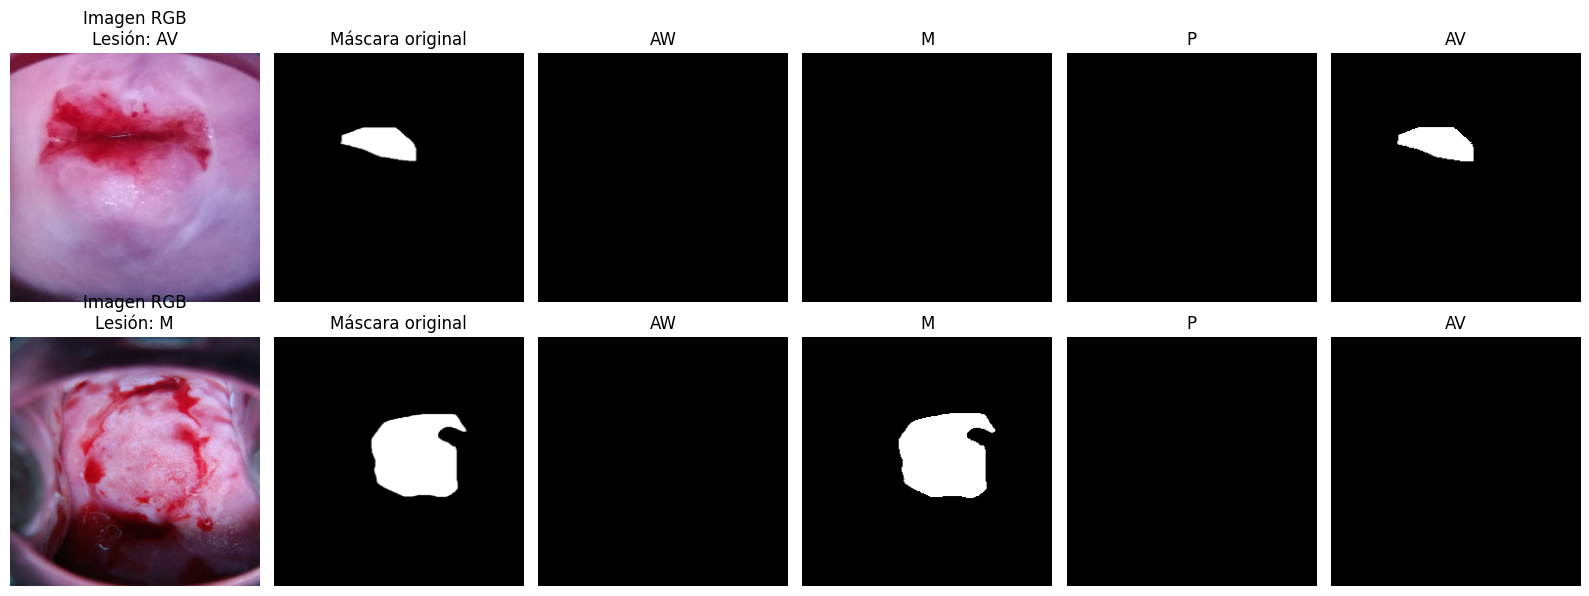

📊 Distribución original: {0: 145, 3: 36, 1: 24, 2: 20}


In [200]:
# 🎨 Visualizar ejemplos
sample_data = []
for i in range(2):
    row = df_imagenes.iloc[i]
    img, mask = load_image_and_mask_color(INTEL_DIR / row["imagen"], INTEL_DIR / row["mascara"], TARGET_SIZE)
    one_hot = create_one_hot_mask(mask, row["lesion"], TARGET_SIZE)
    sample_data.append((img, mask, one_hot, row["lesion"]))

fig, axes = plt.subplots(len(sample_data), 2 + len(lesion_labels), figsize=(16, len(sample_data) * 3))
for i, (img, mask, one_hot, lesion_type) in enumerate(sample_data):
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Imagen RGB\nLesión: {lesion_type.upper()}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title("Máscara original")
    axes[i, 1].axis('off')
    for j, label in enumerate(lesion_labels):
        axes[i, j+2].imshow(one_hot[:, :, j], cmap='gray')
        axes[i, j+2].set_title(f"{label.upper()}")
        axes[i, j+2].axis('off')
plt.tight_layout()
plt.show()

# 📊 Conteo original por clase
counts = df_imagenes["clase"].value_counts().to_dict()
print("📊 Distribución original:", counts)

### 3.2 Aumento de datos y preparación de las etiquetas

In [ ]:
# 🔁 Aumento balanceado
AUG_DIR.mkdir(exist_ok=True)
existing_aug_files = {f.name for f in AUG_DIR.iterdir() if f.is_file()}
for clase in [0, 1, 2, 3]:
    clase_data = df_imagenes[df_imagenes["clase"] == clase]
    total_existente = len(clase_data)
    deficit = max(0, objetivo_por_clase - total_existente)
    generados = 0
    intentos = 0
    while generados < deficit and intentos < deficit * 10:
        row = clase_data.sample(1).iloc[0]
        img = Image.open(INTEL_DIR / row["imagen"]).convert("RGB").resize(TARGET_SIZE)
        mask = Image.open(INTEL_DIR / row["mascara"]).convert("L").resize(TARGET_SIZE)
        aug_img, aug_mask = augment_image(img, mask)
        new_id = f"{row['imagen'].split('.')[0]}_aug{random.randint(10000,99999)}"
        img_name = f"{new_id}.jpg"
        mask_name = f"{new_id}-{row['lesion']}.tif"
        if img_name in existing_aug_files or mask_name in existing_aug_files:
            intentos += 1
            continue
        aug_img.save(AUG_DIR / img_name)
        aug_mask.save(AUG_DIR / mask_name)
        existing_aug_files.update([img_name, mask_name])
        generados += 1



In [ ]:
# 📚 Recontar clases (original + aumentadas)
all_masks = [f for f in os.listdir(INTEL_DIR) + os.listdir(AUG_DIR) if '-' in f and f.endswith('.tif')]
lesion_list = [lesion_classes[get_lesion_type(m)] for m in all_masks if get_lesion_type(m) in lesion_classes]
df_augmented = pd.DataFrame({"clase": lesion_list})

In [ ]:
# 📊 Visualización comparativa
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.countplot(data=df_imagenes, x="clase", palette="Set1", ax=axs[0])
axs[0].set_title("Antes del aumento")
sns.countplot(data=df_augmented, x="clase", palette="Set2", ax=axs[1])
axs[1].set_title("Después del aumento")
plt.suptitle("Distribución de clases")
plt.tight_layout()
plt.show()


In [ ]:
# 📂 División en conjuntos de entrenamiento, validación y prueba
train_val_df, test_df = train_test_split(
    df_augmented, test_size=0.15, stratify=df_augmented["clase"], random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.1765, stratify=train_val_df["clase"], random_state=42
)

# 📊 Mostrar tamaños y proporciones
total = len(df_augmented)
print(f"📚 Total imágenes (aumentadas): {total}")
print(f"✅ Entrenamiento: {len(train_df)} imágenes ({len(train_df)/total:.1%})")
print(f"🧪 Validación:   {len(val_df)} imágenes ({len(val_df)/total:.1%})")
print(f"🧾 Prueba:       {len(test_df)} imágenes ({len(test_df)/total:.1%})")


### 🟩 3.2 Procesamiento de datos clínicos

Se realiza el análisis del dataset `SelectedVarV2.csv` y del conjunto de imágenes + máscaras para:

- Verificar si existen valores nulos en las variables clínicas y específicamente en la columna `edad`.
- Confirmar que todas las imágenes del dataset de segmentación estén correctamente asociadas a una máscara y clase.
- Codificar las clases de lesiones en valores numéricos (`aw` → 0, `m` → 1, etc.), para su uso posterior en modelos de clasificación o evaluación de segmentación multiclase.


In [ ]:
df_selectedvar["class"] = df_selectedvar.apply(
    lambda row: 1 if row["Tabaquismo"] == 1 or row["VacunaVPH"] == 1 else 0,
    axis=1
)

# ===============================
# 🧽 3. Limpiar columnas no útiles
# ===============================
df_selectedvar = df_selectedvar.drop(columns=["codigo", "date"], errors="ignore")

# ==============================
# 📏 4. Estandarizar numéricas
# ==============================
columnas_numericas = ["Edad", "embarazos", "partos", "NumParejaSexual", "EdadinicioSex", "NumPap"]
scaler = StandardScaler()
df_selectedvar[columnas_numericas] = scaler.fit_transform(df_selectedvar[columnas_numericas])

# ===================================
# 🔣 5. Detectar variables categóricas
# ===================================
columnas_categoricas = [col for col in df_selectedvar.columns if col not in columnas_numericas + ["class"]]

# ===============================
# 📊 6. Visualización de variables
# ===============================
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 🎯 Boxplot de numéricas
sns.boxplot(data=df_selectedvar[columnas_numericas], ax=axes[0])
axes[0].set_title("📈 Variables numéricas estandarizadas")
axes[0].tick_params(axis='x', rotation=45)

# 🎯 Countplot de categóricas
df_categoricas_plot = df_selectedvar[columnas_categoricas + ["class"]].melt(
    id_vars="class", var_name="Variable", value_name="Valor"
)
sns.countplot(data=df_categoricas_plot, x="Variable", hue="Valor", ax=axes[1])
axes[1].set_title("📊 Distribución de variables categóricas por clase")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ================================
# 📌 7. Conteo final de clases
# ================================
conteo_clases = df_selectedvar["class"].value_counts().sort_index()
print("📊 Conteo de clases (0 = normal, 1 = anormal):\n")
for clase, total in conteo_clases.items():
    print(f"Clase {clase}: {total} pacientes")


#### 🟩 División de conjuntos de datos clínicos

Se divide el dataset en conjuntos de entrenamiento, validación y prueba usando la variable `class` como etiqueta. Esto permitirá utilizar estos datos en modelos de Machine Learning como Random Forest, SVM y Regresión Logística para predecir el riesgo de cáncer.


In [ ]:
Genera el código unificado que mejore esto entonces_
# 📂 División en conjuntos de entrenamiento, validación y prueba
train_val_df, test_df = train_test_split(
    df_augmented, test_size=0.15, stratify=df_augmented["clase"], random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.1765, stratify=train_val_df["clase"], random_state=42
)

# 📊 Mostrar tamaños y proporciones
total = len(df_augmented)
print(f"📚 Total imágenes (aumentadas): {total}")
print(f"✅ Entrenamiento: {len(train_df)} imágenes ({len(train_df)/total:.1%})")
print(f"🧪 Validación:   {len(val_df)} imágenes ({len(val_df)/total:.1%})")
print(f"🧾 Prueba:       {len(test_df)} imágenes ({len(test_df)/total:.1%})")

## 🔹 4. Modelo UNet – Segmentación y Clasificación de Lesión

#### 📌 Características del modelo:

- **Entrada**: Imagen RGB `(256, 256, 3)`
- **Salida**: Máscara `(256, 256, 4)` con 4 canales (una por clase: AW, M, P, AV)
- **Activación final**: `softmax` (para segmentación multiclase)
- **Función de pérdida**: `categorical_crossentropy`
- **Métricas**: IoU (Intersection over Union) y Dice Score, calculadas por clase (persona

- l### 4.1: Definición de la arquitectura U-Netizadas)


In [ ]:
#✅ 1. Definir el modelo unet

import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(256, 256, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    return Model(inputs, outputs, name="UNet_Multiclass")


In [ ]:
#✅ 2. Compilar el modelo con métricas personalizadas

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# IoU multiclase
def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return tf.reduce_mean(iou)

# Dice Score multiclase
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    summation = tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (summation + smooth)
    
    return tf.reduce_mean(dice)

# Compilación del modelo
model = build_unet(input_shape=(256, 256, 3), num_classes=4)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=[iou_score, dice_score]
)


In [ ]:
# ✅ 2. Data generator (para usar train_df, val_df)

def parse_image_mask(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = tf.cast(mask > 0, tf.uint8)

    # Inferir clase desde el nombre de la máscara
    lesion_code = tf.strings.split(mask_path, '-')[-1]
    lesion_code = tf.strings.regex_replace(lesion_code, ".tif", "")
    clase = tf.switch_case(
        tf.where(lesion_code == "aw", 0,
          tf.where(lesion_code == "m", 1,
          tf.where(lesion_code == "p", 2, 3))),
        branch_fns=[
            lambda: tf.constant([1,0,0,0]),
            lambda: tf.constant([0,1,0,0]),
            lambda: tf.constant([0,0,1,0]),
            lambda: tf.constant([0,0,0,1]),
        ]
    )
    clase = tf.reshape(clase, [1,1,4])
    clase_mask = tf.tile(clase, [256, 256, 1])
    
    return img, clase_mask

def create_dataset(img_paths, mask_paths, batch_size=8, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
#✅ 3. Entrenamiento + visualización por época

from tensorflow.keras.callbacks import Callback

class VisualizePrediction(Callback):
    def __init__(self, val_dataset, n_samples=1):
        super().__init__()
        self.val_dataset = val_dataset
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        import matplotlib.pyplot as plt
        for imgs, masks in self.val_dataset.take(1):
            preds = self.model.predict(imgs)
            for i in range(self.n_samples):
                plt.figure(figsize=(10,3))
                plt.subplot(1,3,1)
                plt.imshow(imgs[i])
                plt.title("Imagen original")
                plt.axis("off")
                plt.subplot(1,3,2)
                plt.imshow(tf.argmax(masks[i], axis=-1), cmap="gray")
                plt.title("Máscara real")
                plt.axis("off")
                plt.subplot(1,3,3)
                plt.imshow(tf.argmax(preds[i], axis=-1), cmap="viridis")
                plt.title("Predicción")
                plt.axis("off")
                plt.suptitle(f"Epoch {epoch+1}")
                plt.tight_layout()
                plt.show()


In [ ]:


# Callbacks
callbacks = [
    VisualizePrediction(val_dataset, n_samples=1),
    tf.keras.callbacks.ModelCheckpoint("modelo_mejorado.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]
# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)